In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace

tf.keras.utils.set_random_seed(999)

In [2]:
# read peopleDevTrain.csv and peopleDevTest.csv
train = pd.read_csv('peopleDevTrain.csv')
test = pd.read_csv('peopleDevTest.csv')

# remove rows with empty 'cropped' column
train = train[train['cropped'].notna()]
test = test[test['cropped'].notna()]

In [3]:
# list of image files in "cropped" column, put into data loader
datagen = ImageDataGenerator(rescale=1./255)
train_loader = datagen.flow_from_dataframe(train, x_col='cropped', target_size=(224, 224), batch_size=32, class_mode='input', seed=42)

val_loader = datagen.flow_from_dataframe(test, x_col='cropped', target_size=(224, 224), batch_size=32, class_mode='input', seed=42)

Found 9482 validated image filenames.
Found 3689 validated image filenames.


In [4]:
model = VGGFace(model='vgg16')

In [5]:
encoder = tf.keras.Model(inputs=model.input, outputs=model.get_layer('pool1').output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


In [6]:
# build decoder
latent = tf.keras.Input(shape=encoder.output.shape[1:])

x = tf.keras.layers.UpSampling2D((2, 2))(latent)
x = tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(3, (3, 3), padding='same', activation='sigmoid')(x)

decoder = tf.keras.Model(inputs=latent, outputs=x)

decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 64)]    0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 64)     0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 224, 224, 64)     36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 224, 224, 3)      1731      
 ranspose)                                                       
                                                                 
Total params: 38,659
Trainable params: 38,659
Non-trainable params: 0
_______________________________________________________

In [7]:
# add preprocessing layers before encoder
image_input = tf.keras.Input(shape=(224, 224, 3))

# scale back to 0-255
x = tf.keras.layers.Lambda(lambda x: x * 255)(image_input)
# change rgb to bgr
x = tf.keras.layers.Lambda(lambda x: x[..., ::-1])(x)
# subtract mean
x = tf.keras.layers.Lambda(lambda x: x - [93.5940, 104.7624, 129.1863])(x)

preprocessor = tf.keras.Model(inputs=image_input, outputs=x)

In [8]:
# set encoder as non-trainable
for layer in encoder.layers:
    layer.trainable = False

model = tf.keras.Sequential([preprocessor, encoder, decoder])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 224, 224, 3)       0         
                                                                 
 model (Functional)          (None, 112, 112, 64)      38720     
                                                                 
 model_1 (Functional)        (None, 224, 224, 3)       38659     
                                                                 
Total params: 77,379
Trainable params: 38,659
Non-trainable params: 38,720
_________________________________________________________________


In [9]:
# train
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(train_loader, validation_data=val_loader, epochs=20)

Epoch 1/20
297/297 [==============================] - 22s 58ms/step - loss: 10.8885 - val_loss: 4.4662
Epoch 2/20
297/297 [==============================] - 16s 54ms/step - loss: 3.5873 - val_loss: 2.9185
Epoch 3/20
297/297 [==============================] - 16s 54ms/step - loss: 2.0873 - val_loss: 1.8020
Epoch 4/20
297/297 [==============================] - 16s 55ms/step - loss: 1.2766 - val_loss: 1.1219
Epoch 5/20
297/297 [==============================] - 16s 55ms/step - loss: 1.0740 - val_loss: 0.8563
Epoch 6/20
297/297 [==============================] - 16s 54ms/step - loss: 0.8984 - val_loss: 0.7916
Epoch 7/20
297/297 [==============================] - 16s 55ms/step - loss: 0.8088 - val_loss: 0.7712
Epoch 8/20
297/297 [==============================] - 16s 55ms/step - loss: 0.7732 - val_loss: 0.7299
Epoch 9/20
297/297 [==============================] - 16s 55ms/step - loss: 0.7282 - val_loss: 0.6974
Epoch 10/20
297/297 [==============================] - 16s 55ms/step - loss: 0.70

1/1 [==============================] - 0s 14ms/step


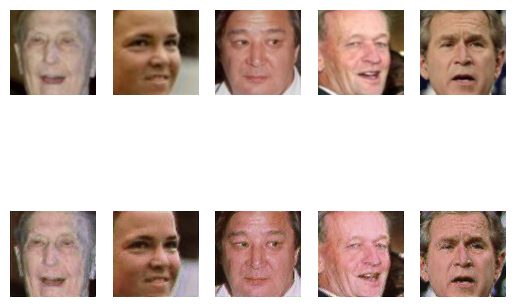

In [10]:
import matplotlib.pyplot as plt

# show 5 train images and their reconstructions
for i in range(5):
    img = train_loader[i][0][0]
    rec = model.predict(np.expand_dims(img, axis=0))[0]
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.imshow(rec)
    plt.axis('off')

1/1 [==============================] - 0s 13ms/step


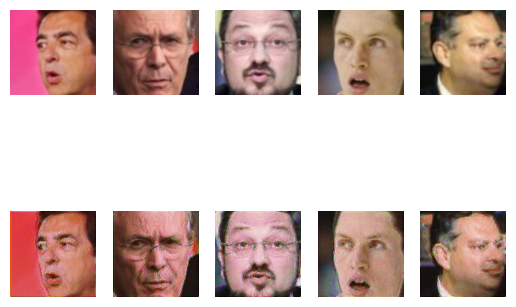

In [11]:
# show 5 test images and their reconstructions
for i in range(5):
    img = val_loader[i][0][0]
    rec = model.predict(np.expand_dims(img, axis=0))[0]
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.imshow(rec)
    plt.axis('off')